Here we will define a class for a custom dataset.

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image


class CustomImageDataset(Dataset):
    """
    Class for custom dataset. It is meant to support creating a new dataset using locally stored images that are labeled in a dataframe.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """
        The inputs : annotation_file is a dataframe and img_dir is a path. 
        annotation_file should have on the first column the image_id (for example 14446.jpg) that represents the name under which the images is saved. On the second column should be the labels.
        img_dir is the path to the directory where the images are saved.
        Function intitialises the object.
        """
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """
        Returns the dimension of the dataset.
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Parameter idx is an integer. Function returns the image stored as tensor and its label, corresponding to the index idx of the dataframe.
        """
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = torch.tensor(self.img_labels.iloc[idx, 1], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

We create the dataset and check a few images and labels. With this dataset we will train the network to answer the first question t01 and to classify the galaxies.

          asset_id  t01_type
0        58957.jpg       1.0
1       193641.jpg       1.0
2        55934.jpg       0.0
3       158501.jpg       1.0
4       110939.jpg       0.0
...            ...       ...
209734   30593.jpg       0.0
209735   74398.jpg       0.0
209736  151540.jpg       0.0
209737  259387.jpg       0.0
209738  262969.jpg       0.0

[209739 rows x 2 columns]


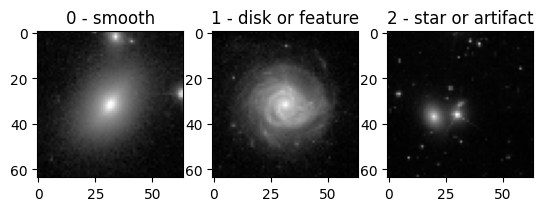

In [12]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.CenterCrop(212),
                                transforms.Resize(64),
                                
                              ])

csv_annotations_file = r"unbalanced_t01.csv"
annotations_file=pd.read_csv(csv_annotations_file)
print(annotations_file)
img_dir=r"images"

t01_galaxies = CustomImageDataset (annotations_file , img_dir, transform=transform)

ap_0=0
ap_1=0
ap_2=0

plt.figure(1)

for i in range(len(t01_galaxies)):

   image, label= t01_galaxies.__getitem__(i)

   if label == 0 and ap_0 == 0:
        plt.subplot(1, 3, 1)
        plt.imshow(  image.permute(1, 2, 0), cmap='gray'  )
        plt.title('0 - smooth')
        ap_0 += 1

   if label == 1 and ap_1 == 0:
      plt.subplot(1, 3, 2)
      plt.imshow(  image.permute(1, 2, 0), cmap='gray'  )
      plt.title('1 - disk or feature')
      ap_1 += 1

   if label == 2 and ap_2 == 0:
      plt.subplot(1, 3, 3)
      plt.imshow(  image.permute(1, 2, 0), cmap='gray'  )
      plt.title('2 - star or artifact')
      ap_2 += 1

   if ap_0 == 1 and ap_1 == 1 and ap_2 == 1:
      break
    

In [13]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
validation_split = .2
test_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(t01_galaxies)
indices = list(range(dataset_size))
split_val = int(np.floor(validation_split * dataset_size))
split_test= int(np.floor(test_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[split_val+split_test:], indices[:split_val], indices[split_val:split_val+split_test]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(t01_galaxies, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(t01_galaxies, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(t01_galaxies, batch_size=batch_size,
                                                sampler=test_sampler)



In [14]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}{train_features.dtype}")
print(f"Labels batch shape: {train_labels.size()}{train_labels.dtype}")

Feature batch shape: torch.Size([32, 1, 64, 64])torch.float32
Labels batch shape: torch.Size([32])torch.int64


In [15]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F


class model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704 , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
t01_model = model1()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(t01_model.parameters(), lr=0.001, momentum=0.9)

epochs = 10

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = t01_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            
print('Finished Training')

[1,   100] loss: 0.896
[1,   200] loss: 0.582
[1,   300] loss: 0.558
[1,   400] loss: 0.545
[1,   500] loss: 0.552
[1,   600] loss: 0.558
[1,   700] loss: 0.546


KeyboardInterrupt: 

In [25]:
PATH = './t01_net.pth'
torch.save(t01_model.state_dict(), PATH)

In [26]:
net = model1()
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 76 %
